In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

In [2]:
device = torch.device('cuda')

In [3]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.conv1_gpu1, self.conv1_gpu2 = [
           nn.Conv2d(
            in_channels=3,
            out_channels=48,
            kernel_size=11,
            stride=4,
            padding=2,
        ) for _ in range(2)
        ]

        self.conv2_gpu1, self.conv2_gpu2 = [
           nn.Conv2d(
            in_channels=48,
            out_channels=128,
            kernel_size=5,
            stride=1,
            padding=2,
        ) for _ in range(2)
        ]

        self.conv3_gpu1, self.conv3_gpu2 = [
            nn.Conv2d(
            in_channels=256,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=1,
        ) for _ in range(2)
        ]

        self.conv4_gpu1, self.conv4_gpu2 = [
            nn.Conv2d(
            in_channels=192,
            out_channels=192,
            kernel_size=3,
            stride=1,
            padding=1,
        ) for _ in range(2)
        ]

        self.conv5_gpu1, self.conv5_gpu2 = [
            nn.Conv2d(
            in_channels=192,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1,
        ) for _ in range(2)
        ]

        self.fc1_gpu1, self.fc1_gpu2 = [nn.Linear(256*6*6, 2048) for _ in range(2)]
        self.dropout1 = nn.Dropout1d(0.5)

        self.fc2_gpu1, self.fc2_gpu2 = [nn.Linear(4096, 2048) for _ in range(2)]
        self.dropout2 = nn.Dropout1d(0.5)

        self.fc_last = nn.Linear(4096, num_classes)

    def forward(self, x):
        out_gpu1 = F.relu(self.conv1_gpu1(x))
        out_gpu2 = F.relu(self.conv1_gpu2(x))
        out_gpu1 = F.max_pool2d(out_gpu1, kernel_size=3, stride=2)
        out_gpu2 = F.max_pool2d(out_gpu2, kernel_size=3, stride=2)

        out_gpu1 = F.relu(self.conv2_gpu1(out_gpu1))
        out_gpu2 = F.relu(self.conv2_gpu2(out_gpu2))
        out_gpu1 = F.max_pool2d(out_gpu1, kernel_size=3, stride=2)
        out_gpu2 = F.max_pool2d(out_gpu2, kernel_size=3, stride=2)

        out = torch.cat([out_gpu1, out_gpu2], dim=1)

        out_gpu1 = F.relu(self.conv3_gpu1(out))
        out_gpu2 = F.relu(self.conv3_gpu2(out))

        out_gpu1 = F.relu(self.conv4_gpu1(out_gpu1))
        out_gpu2 = F.relu(self.conv4_gpu2(out_gpu2))

        out_gpu1 = F.relu(self.conv5_gpu1(out_gpu1))
        out_gpu2 = F.relu(self.conv5_gpu2(out_gpu2))
        out_gpu1 = F.max_pool2d(out_gpu1, kernel_size=3, stride=2)
        out_gpu2 = F.max_pool2d(out_gpu2, kernel_size=3, stride=2)
        
        out = torch.cat([out_gpu1, out_gpu2], dim=1)

        out = out.view(-1, 256*6*6)

        out_gpu1 = F.relu(self.fc1_gpu1(out))
        out_gpu2 = F.relu(self.fc1_gpu2(out))
        out = torch.cat([out_gpu1, out_gpu2], dim=1)
        out = self.dropout1(out)

        out_gpu1 = F.relu(self.fc2_gpu1(out))
        out_gpu2 = F.relu(self.fc2_gpu2(out))
        out = torch.cat([out_gpu1, out_gpu2], dim=1)
        out = self.dropout2(out)

        out = self.fc_last(out)
        
        return out
    
model = AlexNet().to(device)
model

AlexNet(
  (conv1_gpu1): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv1_gpu2): Conv2d(3, 48, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2_gpu1): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_gpu2): Conv2d(48, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_gpu1): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_gpu2): Conv2d(256, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_gpu1): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_gpu2): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_gpu1): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_gpu2): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1_gpu1): Linear(in_features=9216, out_features=2048, bias=True)
  (fc1_gpu2): Linear(in_features=9216, out_features=2048, bias=True)
  (dropout1): Dro

In [8]:
nn.Linear?

Init signature:
nn.Linear(
    in_features: int,
    out_features: int,
    bias: bool = True,
    device=None,
    dtype=None,
) -> None
Docstring:     
Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

Args:
    in_features: size of each input sample
    out_features: size of each output sample
    bias: If set to ``False``, the layer will not learn an additive bias.
        Default: ``True``

Shape:
    - Input: :math:`(*, H_{in})` where :math:`*` means any number of
      dimensions including none and :math:`H_{in} = \text{in\_features}`.
    - Output: :math:`(*, H_{out})` where all but the last dimension
      are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

Attributes:
    weight: the learnable weights of the module of shape
        :math:`(

In [4]:
sum([p.numel() for p in model.parameters()])

60965224

In [ ]:
60965224 / 1e6

In [5]:
for name, p in model.named_parameters():
    print(name, p.shape)

conv1_gpu1.weight torch.Size([48, 3, 11, 11])
conv1_gpu1.bias torch.Size([48])
conv1_gpu2.weight torch.Size([48, 3, 11, 11])
conv1_gpu2.bias torch.Size([48])
conv2_gpu1.weight torch.Size([128, 48, 5, 5])
conv2_gpu1.bias torch.Size([128])
conv2_gpu2.weight torch.Size([128, 48, 5, 5])
conv2_gpu2.bias torch.Size([128])
conv3_gpu1.weight torch.Size([192, 256, 3, 3])
conv3_gpu1.bias torch.Size([192])
conv3_gpu2.weight torch.Size([192, 256, 3, 3])
conv3_gpu2.bias torch.Size([192])
conv4_gpu1.weight torch.Size([192, 192, 3, 3])
conv4_gpu1.bias torch.Size([192])
conv4_gpu2.weight torch.Size([192, 192, 3, 3])
conv4_gpu2.bias torch.Size([192])
conv5_gpu1.weight torch.Size([128, 192, 3, 3])
conv5_gpu1.bias torch.Size([128])
conv5_gpu2.weight torch.Size([128, 192, 3, 3])
conv5_gpu2.bias torch.Size([128])
fc1_gpu1.weight torch.Size([2048, 9216])
fc1_gpu1.bias torch.Size([2048])
fc1_gpu2.weight torch.Size([2048, 9216])
fc1_gpu2.bias torch.Size([2048])
fc2_gpu1.weight torch.Size([2048, 4096])
fc2_gpu

In [5]:
x = torch.zeros([1, 3, 224, 224]).to(device)
output = model(x)
output.shape

torch.Size([1, 1000])

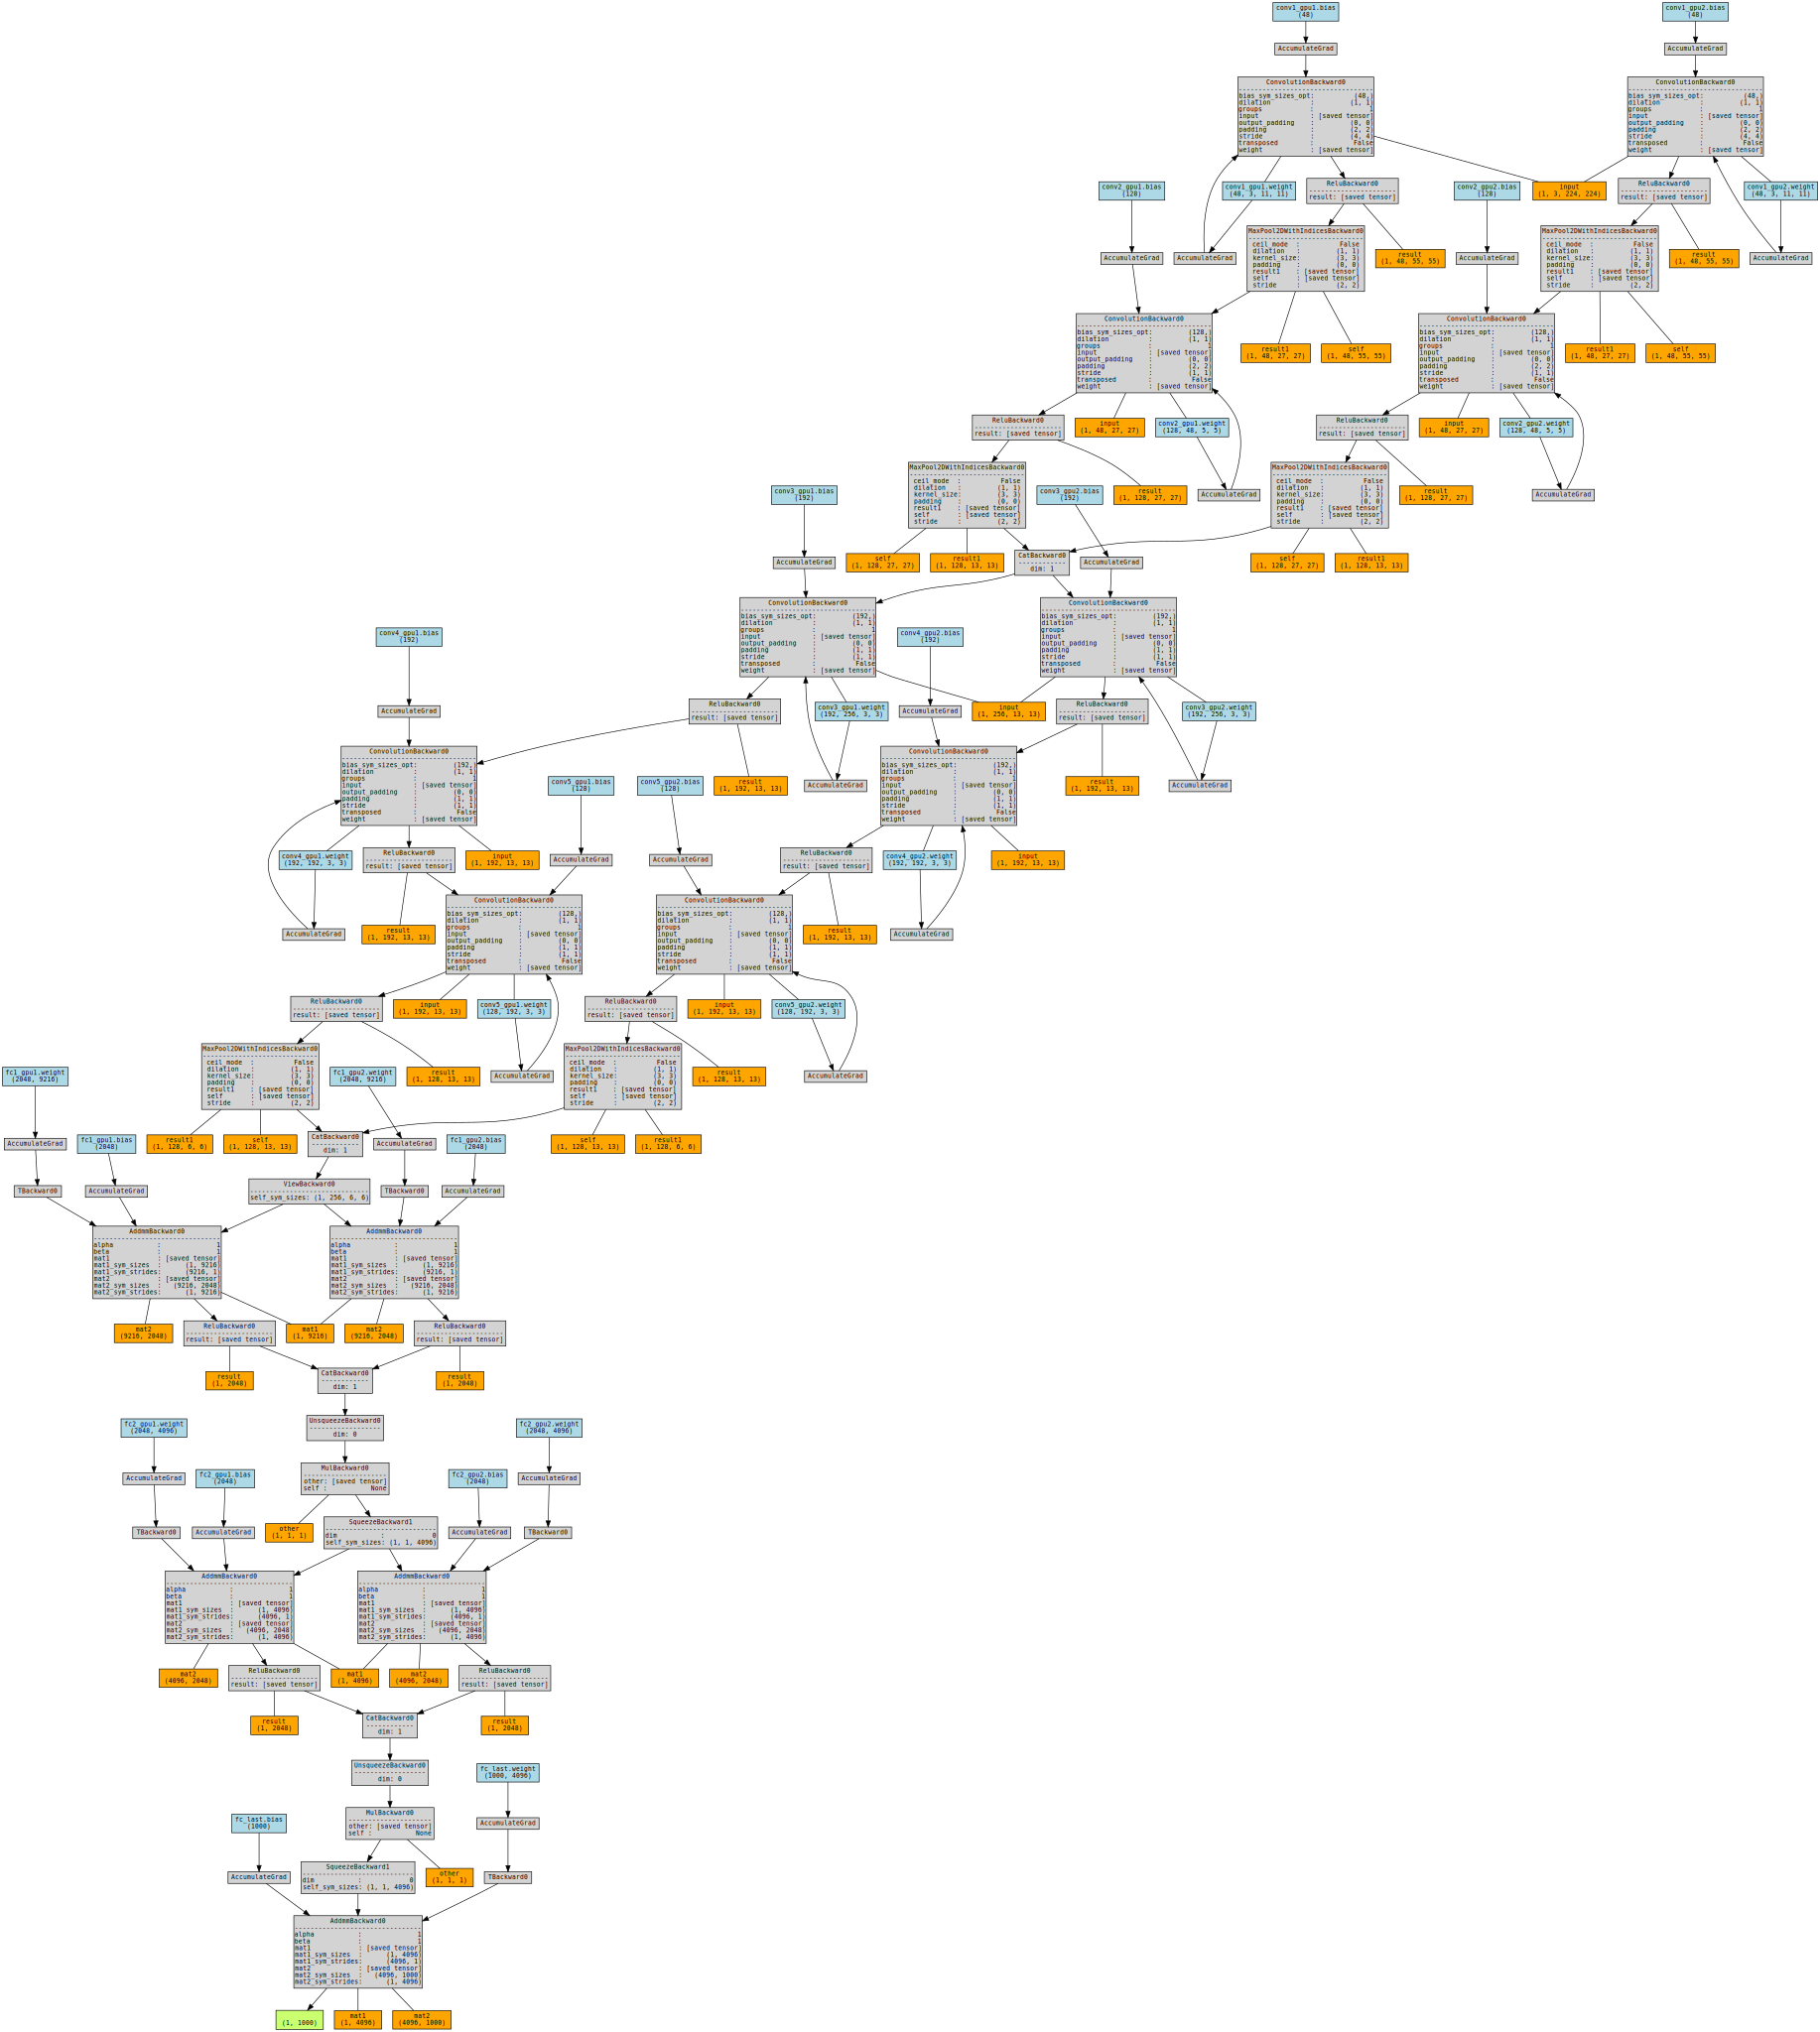

In [6]:
from torchviz import make_dot

make_dot(output, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [7]:
torch.onnx.export(model, x, 'alexnet.onnx', input_names=['Image'], output_names=['Class'])

In [9]:
imagenet_train = datasets.ImageNet(root='imagenet', split='train')
imagenet_train = datasets.ImageNet(root='imagenet', split='val')

RuntimeError: The archive ILSVRC2012_img_train.tar is not present in the root directory or is corrupted. You need to download it externally and place it in imagenet.